In [1]:
"""
Un des enjeu sur le DeepLearning et en particulier le Hs NN du WV est d etre capable
de refaire le meme model heteroskedastic_2017.h5 que celui fourni par Sadowski en feb 2021)
Je vais utilier les mêmes libs et le meme training dataset
A Grouazel
June 2021 : reprise du notebook eponyme pour egere transformation sur experience1 : remplacement des X spectres OCN par SLC
kernel : xsarQuach2020
non finalement: jupyterhub-tensorflow-ric (env conda de Benoit Morin qui marche bien)

"""

'\nUn des enjeu sur le DeepLearning et en particulier le Hs NN du WV est d etre capable\nde refaire le meme model heteroskedastic_2017.h5 que celui fourni par Sadowski en feb 2021)\nJe vais utilier les mêmes libs et le meme training dataset\nA Grouazel\nJune 2021 : reprise du notebook eponyme pour egere transformation sur experience1 : remplacement des X spectres OCN par SLC\nkernel : xsarQuach2020\n\n'

In [1]:
# Train neural network to predict significant wave height from SAR spectra.
# Train with heteroskedastic regression uncertainty estimates.
# Author: Peter Sadowski, Dec 2020
import os, sys
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' # Needed to avoid cudnn bug.
import numpy as np
import h5py

import tensorflow as tf
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

#sys.path = ['../'] + sys.path
sys.path.append('/home1/datahome/agrouaze/git/sar_hs_nn/')
from sarhspredictor.lib.sarhs.generator import SARGenerator
from sarhspredictor.lib.sarhs.heteroskedastic import Gaussian_NLL, Gaussian_MSE

In [2]:
%load_ext tensorboard

# model definition

In [3]:
def define_model():
    # Low-level features.
    inputs = Input(shape=(72, 60, 2))
    x = Conv2D(64, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = GlobalMaxPooling2D()(x)
    x = Dense(256, activation='relu')(x)
    #x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    cnn = Model(inputs, x)

    # High-level features.
    inp = Input(shape=(32, ))  # 'hsSM', 'hsWW3v2', 'hsALT', 'altID', 'target' -> dropped
    x = Dense(units=256, activation='relu')(inp)
    x = Dense(units=256, activation='relu')(x)
    x = Dense(units=256, activation='relu')(x)
    x = Dense(units=256, activation='relu')(x)
    x = Dense(units=256, activation='relu')(x)
    x = Dense(units=256, activation='relu')(x)
    x = Dense(units=256, activation='relu')(x)
    x = Dense(units=256, activation='relu')(x)
    x = Dense(units=256, activation='relu')(x)
    #x = Dropout(0.5)(x)
    x = Dense(units=256, activation='relu')(x)
    #x = Dropout(0.5)(x)
    x = Dense(units=256, activation='relu')(x)
    x = Dropout(0.5)(x)
    ann = Model(inputs=inp, outputs=x)
    
    # Combine
    combinedInput = concatenate([cnn.output, ann.output])
    x = Dense(256, activation="relu")(combinedInput)
    x = Dropout(0.5)(x)
    x = Dense(256, activation="relu", name='penultimate')(x)  
    x = Dropout(0.5)(x)
    x = Dense(2, activation="softplus", name='output')(x)
    model = Model(inputs=[cnn.input, ann.input], outputs=x)
    return model

In [4]:
momo = define_model()
print(momo.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          8448        input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 72, 60, 2)]  0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 256)          65792       dense_2[0][0]                    
____________________________________________________________________________________________

# cell added to get equivalent file sar_hs.h5
 inspired from https://github.com/hawaii-ai/SAR-Wave-Height/blob/master/scripts/create_dataset_from_nc.ipynb
 pas mal de petite modif sur le nom des variables et avec les variables deja assemblees
 
 dataflow:
 training dataset ALT_...nc -> ALT_...processed.nc -> aggregate.h5 -> split by groups .h5

In [5]:

import os, sys, h5py
import numpy as np
import glob
import logging
from importlib import reload
reload(logging)
fmt = '%(asctime)s %(levelname)s %(filename)s(%(lineno)d) %(message)s'
logging.basicConfig(level=logging.INFO,format=fmt,
                        datefmt='%d/%m/%Y %H:%M:%S')

from netCDF4 import Dataset
import time
from dateutil import rrule
import datetime
import traceback
import xarray
out_dd = '/home1/scratch/agrouaze/training_quach_redo_model/exp1/'
in_dd = '/home/datawork-cersat-public/cache/project/mpc-sentinel1/analysis/s1_data_analysis/hs_nn/exp1/training_dataset/v1/' # contains only SLC inputs
in_dd = '/home/datawork-cersat-public/cache/project/mpc-sentinel1/analysis/s1_data_analysis/hs_nn/exp1/training_dataset/v2/' # with both OCN and SLC inputs
in_dd = '/home/datawork-cersat-public/cache/project/mpc-sentinel1/analysis/s1_data_analysis/hs_nn/exp1/training_dataset/v3/' # correction sur les fichier generes + qquasi full dataset (manque 21500 files grossoo modo)
# voir https://trello.com/c/Lo7Jmbjn/541-experiment1-replace-l2-x-spectra-polar-by-slc-x-spectra
sta = datetime.datetime(2015,1,15)
#sta = datetime.datetime(2018,1,1)
#sta = datetime.datetime(2015,12,1)
#sto = datetime.datetime(2016,1,1)
sto = datetime.datetime(2018,12,1)

# normalization training dataset

 # !! this step can bee replaced by the prun call for daily nc file generation : normalization_inputs_exp1_prun_call.py
sys.path.append('/home1/datahome/agrouaze/git/sar_hs_nn/sarhspredictor/lib/')
import normalization_inputs_exp1
reload(normalization_inputs_exp1)

t0 = time.time()
normalization_inputs_exp1.normalize_training_ds(sta,sto,in_dd,out_dd,redo=True)
logging.info('elapsed time : %1.3f s',time.time()-t0)

In [6]:
print('test')

test


# aggregate the monthly processed files

In [6]:
from importlib import reload
from sarhspredictor.bin import aggregate_monthly_training_files
reload(aggregate_monthly_training_files)
import glob
import logging
import time
from importlib import reload
reload(logging)
logging.basicConfig(level=logging.DEBUG)
logging.info('ok')
from importlib import reload
reload(aggregate_monthly_training_files)
#out_dd = '/home1/scratch/agrouaze/training_quach_redo_model/exp1/daily_normalized/'
out_dd = '/home/datawork-cersat-public/cache/project/mpc-sentinel1/analysis/s1_data_analysis/hs_nn/exp1/training_dataset/v3_norm_v7/'
files_src = sorted(glob.glob(os.path.join(out_dd,'*training*h5')))

print(f'Found {len(files_src)} files.')
print(files_src[0])
# file_dest =  "/mnt/lts/nfs_fs02/sadow_lab/preserve/stopa/sar_hs/data/alt/aggregated_ALT.h5"
# file_dest =  "/mnt/tmp/psadow/sar/aggregated_ALT.h5"
# file_dest = "/mnt/tmp/psadow/sar/aggregated_2019.h5"
# file_dest =  "/mnt/lts/nfs_fs02/sadow_lab/preserve/stopa/sar_hs/data/alt/aggregated_2019.h5"
file_dest = os.path.join('/home1/scratch/agrouaze/training_quach_redo_model/exp1',"aggregated.h5")
file_dest = os.path.join('/home1/scratch/agrouaze/training_quach_redo_model/exp1',"aggregated_test_toto.h5")
# keys = ['timeSAR', 'timeALT', 'lonSAR', 'lonALT', 'latSAR', 'latALT', 'hsALT', 'dx', 'dt', 'nk', 'hsSM', 'incidenceAngle', 'sigma0', 'normalizedVariance', 'S']
# keys = ['timeSAR', 'lonSAR',  'latSAR', 'incidenceAngle', 'sigma0', 'normalizedVariance', 'S']
# keys += ['cspcRe', 'cspcIm']
# keys = ['timeSAR', 'lonSAR',  'latSAR', 'incidenceAngle', 'sigma0', 'normalizedVariance', 'py_S', 'cspcRe', 'cspcIm'] #'py_cspcRe', 'py_cspcIm']
keys = ['timeSAR','timeALT','lonSAR','lonALT','latSAR','latALT','hsALT','dx','dt','nk','hsSM','incidenceAngle','sigma0',
        'normalizedVariance','cspcRe_slc','cspcIm_slc','cspcRe_ocn','cspcIm_ocn','cwave','cwave_ocn','todSAR','py_S','py_S_ocn'] #OCN inputs added
t0 = time.time()
aggregate_monthly_training_files.aggregate(files_src,file_dest,keys=keys)
logging.info('done in %1.3f seconds',time.time()-t0)
logging.info('datetime.today : %s',datetime.datetime.today())

INFO:root:ok
DEBUG:root:date parsed: 20150117
INFO:root:shape cspcRe_slc : (None, 60, 72) shape timeALT (None, 1)
DEBUG:root:date parsed: 20150118
INFO:root:shape cspcRe_slc : 47 shape timeALT 47


no tqdm
no tqdm
Found 1698 files.
/home/datawork-cersat-public/cache/project/mpc-sentinel1/analysis/s1_data_analysis/hs_nn/exp1/training_dataset/v3_norm_v7/S1A_training_exp1_Hs_NN_regression_20150117.h5


DEBUG:root:date parsed: 20150119
INFO:root:shape cspcRe_slc : 164 shape timeALT 164
DEBUG:root:date parsed: 20150120
INFO:root:shape cspcRe_slc : 179 shape timeALT 179
DEBUG:root:date parsed: 20150210
INFO:root:shape cspcRe_slc : 188 shape timeALT 188
DEBUG:root:date parsed: 20150211
INFO:root:shape cspcRe_slc : 198 shape timeALT 198
DEBUG:root:date parsed: 20150212
INFO:root:shape cspcRe_slc : 342 shape timeALT 342
DEBUG:root:date parsed: 20150213
INFO:root:shape cspcRe_slc : 380 shape timeALT 380
DEBUG:root:date parsed: 20150214
INFO:root:shape cspcRe_slc : 401 shape timeALT 401
DEBUG:root:date parsed: 20150215
INFO:root:shape cspcRe_slc : 433 shape timeALT 433
DEBUG:root:date parsed: 20150216
INFO:root:shape cspcRe_slc : 477 shape timeALT 477
DEBUG:root:date parsed: 20150217
INFO:root:shape cspcRe_slc : 657 shape timeALT 657
DEBUG:root:date parsed: 20150218
INFO:root:shape cspcRe_slc : 701 shape timeALT 701
DEBUG:root:date parsed: 20150219
INFO:root:shape cspcRe_slc : 736 shape time

NameError: name 'datetime' is not defined

# split by groups

In [ ]:
# the training dataset must be separated into sub groups
# long long task (about 30min)
import split_aggregated_into_groups
import logging
from importlib import reload
reload(logging)
logging.basicConfig(level=logging.INFO)
import time
from importlib import reload
reload(split_aggregated_into_groups)
file_src2 = os.path.join('/home1/scratch/agrouaze/training_quach_redo_model/exp1',"aggregated_test_toto.h5")
print('source ',file_src2)
file_dest2 = '/home1/scratch/agrouaze/training_quach_redo_model/aggregated_grouped_final_exp1.h5'
file_dest2 = '/home1/scratch/agrouaze/training_quach_redo_model/aggregated_grouped_final_exp1_per_year.h5'
file_dest2 = '/home1/scratch/agrouaze/training_quach_redo_model/aggregated_grouped_final_exp1_per_year_v21sept2021.h5'
if os.path.exists(file_dest2):
    os.remove(file_dest2)
t0 = time.time()
split_aggregated_into_groups.split_aggregated_ds_v2(file_src2,file_dest2,test2015=False,exp_id=1)
#split_aggregated_into_groups.split_aggregated_ds_v3(file_src2,file_dest2,exp_id=1) # split 80% 20%
logging.info('done in %1.3f seconds',time.time()-t0)

INFO:root:start splitting into groups
INFO:root:start creating the final .h5 file
INFO:root:group_name: 2015_2016 years: [2015, 2016]


source  /home1/scratch/agrouaze/training_quach_redo_model/exp1/aggregated_test_toto.h5


INFO:root:indices 2015 (617911,) 43809
INFO:root:indices 2016 (617911,) 252260
INFO:root:assert that no NaN in high level features!! indices before : 252260
INFO:root:indices sum after lat : 252260
INFO:root:indices sum after lon : 252260
INFO:root:indices sum after inc : 252260
INFO:root:indices sum after dx : 252260
INFO:root:indices sum after dt : 252260
INFO:root:indices sum after time : 252260
INFO:root:indices sum after tod : 252260
INFO:root:indices sum after sat : 252260
INFO:root:indices sum after hsalt : 252260
INFO:root:cspcIm_slc shape : (617911, 60, 72)
INFO:root:indices sum after Im : 237193
INFO:root:indices sum after Re : 237193
INFO:root:Found 237193 events from years: [2015, 2016] 
INFO:root:fs[cspcRe_slc] : (617911, 60, 72)
INFO:root:tmpIm_slc : (237193, 72, 60)
INFO:root:fs[cspcRe_ocn] : (617911, 72, 60)
INFO:root:tmpIm : (237193, 72, 60)


In [10]:
import datetime
import os
batch_size = 128
tblogdir = os.path.join('/home1/scratch/agrouaze/tmp/','exp_1')
tensorBoard = TensorBoard(
        log_dir = tblogdir,
        histogram_freq = 1,
        batch_size = batch_size,
        write_graph = True,
        write_grads = False,
        write_images = False,
        embeddings_freq = 0,
        embeddings_layer_names = None,
        embeddings_metadata = None,
        embeddings_data = None,
        update_freq = 'epoch')

In [9]:
os.environ['TENSORBOARD_BINARY'] = '/home1/datawork/agrouaze/conda_envs2/envs/xsarQuach2020/bin/tensorboard'
%tensorboard --logdir tblogdir

# training keras

In [29]:
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'
# Train
import pickle
from tensorflow.keras.callbacks import History
from sarhspredictor.config import model_IFR_replication_quach2020_sadowski_release_5feb2021
import sarhspredictor.lib.sarhs.generator
reload(sarhspredictor.lib.sarhs.generator)
print('gege',sarhspredictor.lib.sarhs.generator.__file__)

#file_model = '/home1/scratch/agrouaze/heteroskedastic_2017_agrouaze.h5'
#file_model = model_IFR_replication_quach2020_sadowski_release_5feb2021 #
file_dest2 = '/home1/scratch/agrouaze/training_quach_redo_model/aggregated_grouped_final_exp1.h5'
print('file_dest2',file_dest2,os.path.exists(file_dest2),type(file_dest2))
import netCDF4
dstmp = h5py.File(file_dest2,'r')
#dstmp = netCDF4.Dataset(file_dest2)
levelinputs = 'ocn'
levelinputs = 'slc'
exp='exp1'
file_model = '/home1/scratch/agrouaze/training_quach_redo_model/trained_model_%s_%s_nbpts_training_%s.h5'%(exp,levelinputs,len(dstmp['training_dataset/latlonSARcossin'][:]))
dstmp.close()
print('file_model output that will be saved',file_model)
histocalbk = History()
model = define_model()
#model.compile(loss=Gaussian_NLL, optimizer=Adam(lr=0.0001), metrics=[Gaussian_MSE]) #original
model.compile(loss=Gaussian_NLL, optimizer=Adam(lr=0.00005), metrics=[Gaussian_MSE])
# Dataset

epochs = 50
#filename = '../../data/alt/sar_hs.h5'
#filename = '/mnt/tmp/psadow/sar/sar_hs.h5'
filename = file_dest2
print('input',file_dest2)
# train = SARGenerator(filename=filename, 
#                      subgroups=['group_1', 'group_2'], 
#                      batch_size=batch_size)
# valid = SARGenerator(filename=filename, subgroups=['group_3'], batch_size=batch_size)

train = sarhspredictor.lib.sarhs.generator.SARGenerator(filename=filename, 
                     subgroups=['training_dataset'], 
                     batch_size=batch_size,exp=int(exp.replace('exp','')),levelinputs=levelinputs)
logging.info('train prepared')
valid = sarhspredictor.lib.sarhs.generator.SARGenerator(filename=filename, subgroups=['validation_dataset'],
                    batch_size=batch_size,exp=int(exp.replace('exp','')),levelinputs=levelinputs)
# filename = '/mnt/tmp/psadow/sar/sar_hs.h5'
# epochs = 25
# train = SARGenerator(filename=filename, 
#                      subgroups=['2015_2016', '2017', '2018'], # Train on all data without early stopping.
#                      batch_size=batch_size)

# Callbacks
# This LR schedule is slower than in the paper.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=1) 
check = ModelCheckpoint(file_model, monitor='val_loss', verbose=0,
                        save_best_only=True, save_weights_only=False,
                        mode='auto', save_freq='epoch')
stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, 
                     mode='auto', baseline=None, restore_best_weights=False)
clbks = [reduce_lr, check, stop,tensorBoard,histocalbk]

history = model.fit(train,
                    epochs=epochs,
                    validation_data=valid,
                    callbacks=clbks,
                    verbose=1)
output_saved_file_history = file_model.replace('trained_model','trained_history')
fid = open(output_saved_file_history,'wb')
pickle.dump(history,fid)
fid.close()
print('output_saved_file_history',output_saved_file_history)
version_model_utput = 1
#outputmodel = '/home1/datawork/agrouaze/model_Hs_NN_WV_ALTIcwaveV4_regression_exp1_%s.h5'%version_model_utput
#model.save(outputmodel)
print('training done')

INFO:root:correction apllied
INFO:root:train prepared
INFO:root:correction apllied


gege /home1/datahome/agrouaze/git/sar_hs_nn/sarhspredictor/lib/sarhs/generator.py
file_dest2 /home1/scratch/agrouaze/training_quach_redo_model/aggregated_grouped_final_exp1.h5 True <class 'str'>
file_model output that will be saved /home1/scratch/agrouaze/training_quach_redo_model/trained_model_exp1_slc_nbpts_training_35503.h5
input /home1/scratch/agrouaze/training_quach_redo_model/aggregated_grouped_final_exp1.h5
Epoch 1/50
278/278 [==============================] - 26s 89ms/step - loss: 3.6234 - Gaussian_MSE: 4.1552 - val_loss: 1.3436 - val_Gaussian_MSE: 1.1811
Epoch 2/50
278/278 [==============================] - 4s 14ms/step - loss: 1.4517 - Gaussian_MSE: 2.0730 - val_loss: 1.1120 - val_Gaussian_MSE: 0.6586
Epoch 3/50
278/278 [==============================] - 4s 14ms/step - loss: 1.2570 - Gaussian_MSE: 1.0276 - val_loss: 1.0104 - val_Gaussian_MSE: 0.5906
Epoch 4/50
278/278 [==============================] - 4s 14ms/step - loss: 1.1600 - Gaussian_MSE: 0.9370 - val_loss: 0.9844 - va

TypeError: cannot pickle 'weakref' object

dict_keys(['loss', 'Gaussian_MSE', 'val_loss', 'val_Gaussian_MSE', 'lr'])


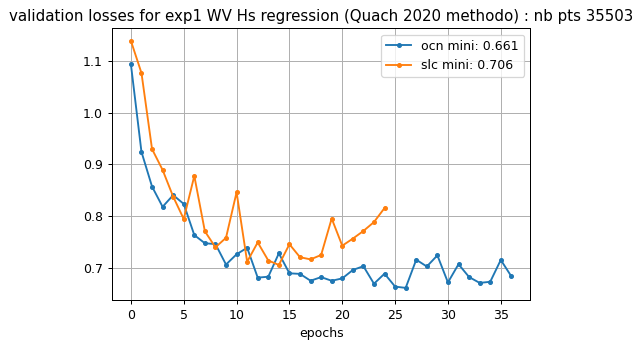

In [28]:
# je veux faire un plot de la loss (moi meme)
# from tensorflow.keras.models import Model, load_model
# from sarhspredictor.lib.sarhs.heteroskedastic import Gaussian_NLL, Gaussian_MSE
# toto_ocn = load_model('/home1/scratch/agrouaze/training_quach_redo_model/trained_model_exp1_ocn_nbpts_training_6583.h5',
#                       custom_objects={'Gaussian_NLL' : Gaussian_NLL,'Gaussian_MSE' : Gaussian_MSE})
# print(toto_ocn)
# print(dir(toto_ocn))
# print(toto_ocn.compiled_loss)
import copy
if levelinputs=='ocn':
    history_ocn = copy.copy(history)
else:
    history_slc = copy.copy(history)
print(history.history.keys())
from matplotlib import pyplot as plt
plt.figure(dpi=90)
plt.grid(True)
plt.title('validation losses for exp1 WV Hs regression\n (Quach 2020 methodo) : nb pts %s'%os.path.basename(file_model).split('_')[6].replace('.h5',''))
plt.plot(history_ocn.history['val_loss'],'.-',label='ocn mini: %1.3f'%np.amin(history_ocn.history['val_loss']))
plt.plot(history_slc.history['val_loss'],'.-',label='slc mini: %1.3f'%np.amin(history_slc.history['val_loss']))
plt.legend()
plt.xlabel('epochs')
plt.ylabel('Gaussian_MSE')
plt.show()

# superimpose loss with different nb pts experiments

6 ['/home1/scratch/agrouaze/training_quach_redo_model/trained_model_exp1_slc_nbpts_training_35503.h5', '/home1/scratch/agrouaze/training_quach_redo_model/trained_model_exp1_ocn_nbpts_training_35503.h5', '/home1/scratch/agrouaze/training_quach_redo_model/trained_model_exp1_ocn_nbpts_training_6583.h5', '/home1/scratch/agrouaze/training_quach_redo_model/trained_model_exp1_slc_nbpts_training_15350.h5', '/home1/scratch/agrouaze/training_quach_redo_model/trained_model_exp1_ocn_nbpts_training_15350.h5', '/home1/scratch/agrouaze/training_quach_redo_model/trained_model_exp1_slc_nbpts_training_6583.h5']
momo None
momo None
momo None
momo None
momo None


momo None


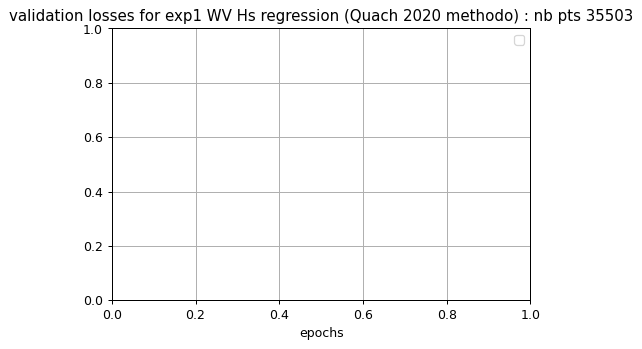

In [25]:
from tensorflow.keras.models import load_model
from sarhspredictor.lib.sarhs.heteroskedastic import Gaussian_NLL, Gaussian_MSE
lst_exp = glob.glob('/home1/scratch/agrouaze/training_quach_redo_model/trained_history_*h5')
print(len(lst_exp),lst_exp)
plt.figure(dpi=90)
plt.grid(True)
plt.title('validation losses for exp1 WV Hs regression (Quach 2020 methodo) : nb pts %s'%os.path.basename(file_model).split('_')[6].replace('.h5',''))
for llmod in lst_exp:
    momo = load_model(llmod,custom_objects={'Gaussian_NLL' : Gaussian_NLL,'Gaussian_MSE' : Gaussian_MSE})
    print('momo',momo.history)
    if momo.history:
        level=  os.path.basename(llmod).split('_')[3]
        nbpts = os.path.basename(llmod).split('_')[6].replace('.h5','')
        plt.plot(momo.history['val_loss'],'.-',label='%s pts %s mini: %1.3f'%(level,nbpts,np.amin(momo.history['val_loss'])))

plt.legend()
plt.xlabel('epochs')
plt.show()

# same training bu using the method in .py script

In [8]:
import training_Hs_regression_exp1
from importlib import reload
reload(training_Hs_regression_exp1)
best_mse,best_loss,best_mae,best_mape,best_cos = training_Hs_regression_exp1.start_training(learning_rate=0.0001,batch_size = 128,drop_out=0.5,tblogdir=tblogdir,save_model=False)

/home1/datahome/agrouaze/sources/sentinel1/hs_total/validation_quach2020/heteroskedastic_2017_agrouaze.h5
/home1/scratch/agrouaze/training_quach_redo_model/aggregated_grouped_final_exp1.h5
Epoch 1/123
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
79/79 [==============================] - 18s 196ms/step - loss: 4.5710 - Gaussian_MSE: 6.1080 - mae: 1.8890 - mape: 62.6777 - cosine_similarity: 1.3575 - val_loss: 1.9631 - val_Gaussian_MSE: 2.9083 -

KeyError: 'mean_squared_error'

In [9]:
dir(history)

NameError: name 'history' is not defined

# test impact of the shuffle on different high level features on the MSE
 using the advertial loss tool 

In [17]:
import neural_structured_learning as nsl
features = train
labels = ['oto']
loss_fn = Gaussian_MSE
res_adversarial_loss = nsl.keras.adversarial_loss(
    features, labels, model, loss_fn, sample_weights=None, adv_config=None,
    predictions=None, labeled_loss=None, gradient_tape=None, model_kwargs=None
)

ValueError: Passed in object of type <class 'sarhspredictor.lib.sarhs.generator.SARGenerator'>, not tf.Tensor

# bon vu que jai des erreurs de deconnexion avec le notebook daatrmor -> je passe en batch voir training_Hs_regression_exp1.py et .pbs associé